# Qno1
Write a modularized python code to predict the number of Lynx (an animal) trapped 
in a forest. Use time series forecasting and linear regression to predict the future 
values. Use a 70-30 percent train test split ratio.

In [6]:
# Import required packages
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
import os
import warnings
import matplotlib.pyplot as plt 
import seaborn as sns
warnings.filterwarnings("ignore")

In [7]:
# split a univariate time series into patterns
def get_Patterns(TSeries, n_inputs,h):
    X,y,z = pd.DataFrame(np.zeros((len(TSeries)-n_inputs-h+1,n_inputs))), pd.DataFrame(), pd.DataFrame()
    for i in range(len(TSeries)):
        # find the end of this pattern
        end_ix = i + n_inputs + h - 1
        # check if we are beyond the time series
        if end_ix > len(TSeries)-1:
            break
        # gather input and output parts of the pattern
        for j in range(n_inputs):
            X.loc[i,j]=TSeries.iloc[i+j,0]
        i=i+n_inputs
        #y=y.append(TSeries.iloc[end_ix], ignore_index = True)
        y=pd.concat([y, TSeries.iloc[end_ix]], ignore_index=True)
        sinX=pd.DataFrame(np.sin(X))
        cosX=pd.DataFrame(np.cos(X))
        squareX=pd.DataFrame(np.power(X,2))
        #X1=pd.concat([X,sinX,cosX,squareX], axis=1)
        X1=X
    return pd.DataFrame(X),pd.DataFrame(y)

In [8]:
# originalData should be a Column Vectored DataFrame
def minmaxNorm(originalData, lenTrainValidation):
    max2norm=max(originalData.iloc[0:lenTrainValidation,0])
    min2norm=min(originalData.iloc[0:lenTrainValidation,0])
    lenOriginal=len(originalData)
    normalizedData=np.zeros(lenOriginal)   
    normalizedData = []
    for i in range (lenOriginal):
        normalizedData.append((originalData.iloc[i]-min2norm)/(max2norm-min2norm))    
    return pd.DataFrame(normalizedData)

In [9]:
# originalData and forecastedData should be Column Vectored DataFrames
def minmaxDeNorm( originalData, forecastedData, lenTrainValidation):
    # Maximum Value
    max2norm=max(originalData.iloc[0:lenTrainValidation,0])
    # Minimum Value
    min2norm=min(originalData.iloc[0:lenTrainValidation,0])
    lenOriginal=len(originalData)
    denormalizedData=[]   
    #De-Normalize using Min-Max Normalization
    for i in range (lenOriginal):
        denormalizedData.append((forecastedData.iloc[i]*(max2norm-min2norm))+min2norm)  
    return pd.DataFrame(denormalizedData)

In [10]:
# Timeseries_Data and forecasted_value should be Column Vectored DataFrames
def findRMSE( Timeseries_Data, forecasted_value,lenTrainValidation):
    l=Timeseries_Data.shape[0]
    lenTest=l-lenTrainValidation
    # RMSE on Train & Validation Set
    trainRMSE=0;
    for i in range (lenTrainValidation):
        trainRMSE=trainRMSE+np.power((forecasted_value.iloc[i,0]-Timeseries_Data.iloc[i,0]),2) 
    trainRMSE=np.sqrt(trainRMSE/lenTrainValidation)
    # RMSE on Test Set
    testRMSE=0;
    for i in range (lenTrainValidation,l,1):
        testRMSE=testRMSE+np.power((forecasted_value.iloc[i,0]-Timeseries_Data.iloc[i,0]),2)
    testRMSE=np.sqrt(testRMSE/lenTest)
    return trainRMSE, testRMSE 

In [11]:
# Timeseries_Data and forecasted_value should be Column Vectored DataFrames
def findMAE(Timeseries_Data, forecasted_value,lenTrainValidation):
    l=Timeseries_Data.shape[0]
    lenTest=l-lenTrainValidation
    # MAE on Train & Validation Set
    trainMAE=0;
    for i in range (lenTrainValidation):
        trainMAE=trainMAE+np.abs(forecasted_value.iloc[i,0]-Timeseries_Data.iloc[i,0]) 
    trainMAE=(trainMAE/(lenTrainValidation));
    # MAE on Test Set
    testMAE=0;
    for i in range (lenTrainValidation,l,1):
        testMAE=testMAE+np.abs(forecasted_value.iloc[i,0]-Timeseries_Data.iloc[i,0])
    testMAE=(testMAE/lenTest);
    return trainMAE, testMAE

In [12]:
def Find_Fitness(x,y,lenValid,lenTest,model):
    NOP=y.shape[0]
    lenTrain=NOP-lenValid-lenTest
    xTrain=x.iloc[0:lenTrain,:]
    xValid=x.iloc[lenTrain:(lenTrain+lenValid),:]
    xTest=x.iloc[(lenTrain+lenValid):NOP,:]
    yTrain=y.iloc[0:lenTrain,0]
    yValid=y.iloc[lenTrain:(lenTrain+lenValid),0]
    yTest=y.iloc[(lenTrain+lenValid):NOP,0]
    model.fit(xTrain, yTrain)
    yhatNorm=model.predict(x).flatten().reshape(x.shape[0],1)
    return pd.DataFrame(yhatNorm)

In [13]:
#Read the Time Series Dataset
Timeseries_Data=pd.read_csv('Lynx.csv',header=None)
print(Timeseries_Data.head())
Timeseries_Data.describe()

      0
0   269
1   321
2   585
3   871
4  1475


,0
count,114.000000
mean,1538.017544
std,1585.843914
min,39.000000
25%,348.250000
50%,771.000000
75%,2566.750000
max,6991.000000


The Autocorrelation plot for the data is:


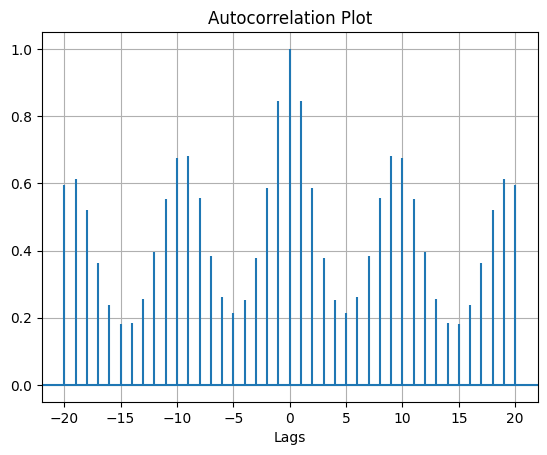

In [14]:
plt.title("Autocorrelation Plot") 
# Providing x-axis name.
plt.xlabel("Lags") 
# Plotting the Autocorrelation plot.
plt.acorr(np.array(Timeseries_Data.iloc[:,0], dtype=float), maxlags = 20) 
# Displaying the plot.
print("The Autocorrelation plot for the data is:")
plt.grid(True)
plt.show() 

<Axes: ylabel='Count'>

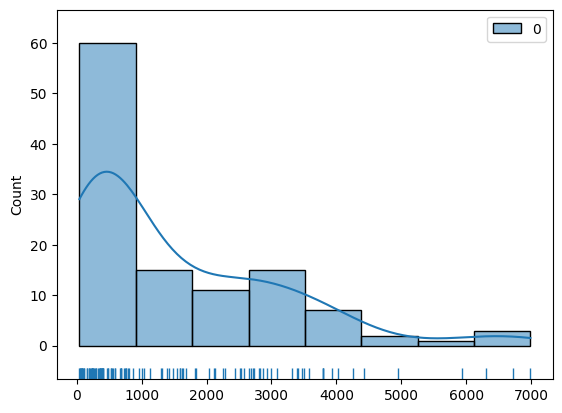

In [15]:
#4. Rug plot — sns.rugplot()
sns.rugplot(data=Timeseries_Data, height=.03, color='darkblue')
sns.histplot(data=Timeseries_Data, kde=True)

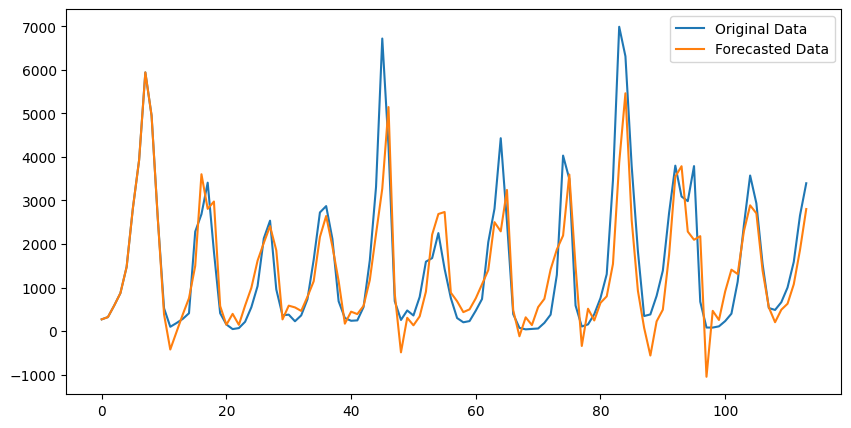

            0           1           2         3
0  804.186429  543.701142  530.371979  440.0537


In [79]:
LagLength=10
h=1
lt=Timeseries_Data.shape[0]
lenTrain=int(round(lt*0.7))
lenValidation=int(round(lt*0.15))
lenTest=int(lt-lenTrain-lenValidation)
# NORMALIZE THE DATA
normalizedData=minmaxNorm(Timeseries_Data,lenTrain+lenValidation);
# Transform the Time Series into Patterns Using Sliding Window
X, y = get_Patterns(normalizedData, LagLength, h)
model=LinearRegression()
name='LinearRegression'
file1='./'+str(name)+"_Accuracy.xlsx"
file2='./'+str(name)+"_Forecasts.xlsx"
Forecasts=pd.DataFrame()
Accuracy=pd.DataFrame()

ynorm1=Find_Fitness(X,y,lenValidation,lenTest,model)
ynorm=pd.DataFrame(normalizedData.iloc[0:(LagLength+h-1),0])
ynorm=pd.concat([ynorm, ynorm1], ignore_index=True)

yhat=minmaxDeNorm(Timeseries_Data, ynorm, lenTrain+lenValidation)
Accuracy.loc[0,0],Accuracy.loc[0,1]=findRMSE( Timeseries_Data,yhat,lenTrain+lenValidation)
Accuracy.loc[0,2],Accuracy.loc[0,3]=findMAE( Timeseries_Data,yhat,lenTrain+lenValidation)
Forecasts=pd.concat([Forecasts, yhat.T], ignore_index=True)
Accuracy.to_excel(file1,sheet_name='Accuracy',index=False)
Forecasts.to_excel(file2,sheet_name='Forecasts',index=False)

plt.figure(figsize=(10,5))
plt.plot(Timeseries_Data, label='Original Data')
plt.plot(yhat, label='Forecasted Data')
plt.legend()
plt.show()
print(Accuracy)

# Qno 2
Write a modularized python code to predict the number of Lynx (an animal) trapped 
in a forest. Use time series forecasting and Multilayer Perceptron (MLP) model to 
predict the future values. Since MLP is a stochastic model, repeat the simulations for 
10 independent times and measure the mean of train and test RMSE and MAE. Use a 
70-30 percent train test split ratio.

            0           1          2           3
0  798.958089  543.357234  473.40094  450.112131


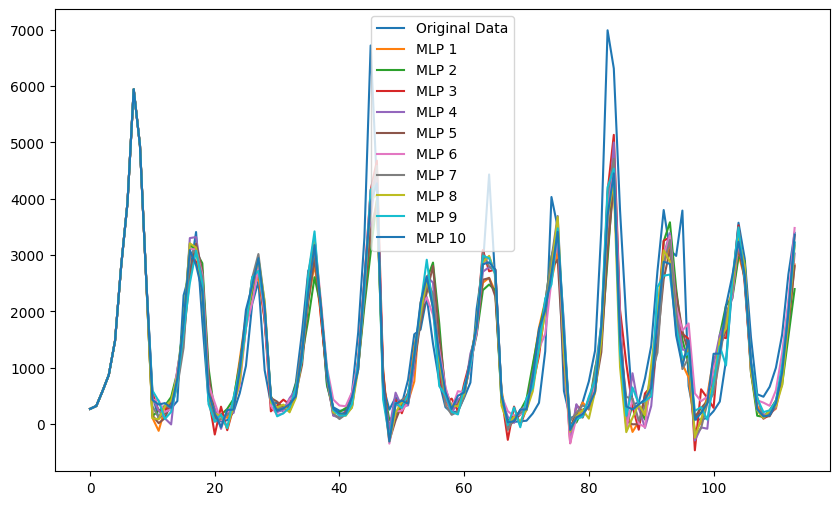

In [17]:
from sklearn.neural_network import MLPRegressor

LagLength=10
h=1
lt=Timeseries_Data.shape[0]
lenTrain=int(round(lt*0.7))
lenValidation=int(round(lt*0.15))
lenTest=int(lt-lenTrain-lenValidation)
# NORMALIZE THE DATA
normalizedData=minmaxNorm(Timeseries_Data,lenTrain+lenValidation);
# Transform the Time Series into Patterns Using Sliding Window
X, y = get_Patterns(normalizedData, LagLength, h)

plt.figure(figsize=(10,6))
plt.plot(Timeseries_Data, label='Original Data')

sumAcc=pd.DataFrame()
for i in range(1,11):
    model=MLPRegressor(hidden_layer_sizes=(100,100), activation='relu', solver='adam', batch_size='auto',
                        learning_rate='constant', learning_rate_init=0.001, shuffle=True,
                        random_state=None)

    name='MLP'
    file1='./'+str(name)+"_Accuracy.xlsx"
    file2='./'+str(name)+"_Forecasts.xlsx"
    Forecasts=pd.DataFrame()
    Accuracy=pd.DataFrame()

    ynorm1=Find_Fitness(X,y,lenValidation,lenTest,model)
    ynorm=pd.DataFrame(normalizedData.iloc[0:(LagLength+h-1),0])
    ynorm=pd.concat([ynorm, ynorm1], ignore_index=True)

    yhat=minmaxDeNorm(Timeseries_Data, ynorm, lenTrain+lenValidation)
    Accuracy.loc[0,0],Accuracy.loc[0,1]=findRMSE( Timeseries_Data,yhat,lenTrain+lenValidation)
    Accuracy.loc[0,2],Accuracy.loc[0,3]=findMAE( Timeseries_Data,yhat,lenTrain+lenValidation)

    plt.plot(yhat, label=f'MLP {i}')

    sumAcc=pd.concat([sumAcc, Accuracy], ignore_index=True)

Accuracy.loc[0,0]=sumAcc.iloc[:,0].mean()

Accuracy.to_excel(file1,sheet_name='Accuracy',index=False)
Forecasts.to_excel(file2,sheet_name='Forecasts',index=False)
print(Accuracy)

plt.legend()
plt.show()



# Qno 3
Test whether the Lynx time series has cyclicity or not. If it has cyclicity, what is the 
cyclicity length? Plot the autocorrelation plot and draw inferences from it. Treat the 
cyclicity by subtracting cyclic average and model it using Linear Regression and 
Predict the future values. Use a 70-30 percent train test split ratio

In [18]:
def load_data():
    lynx_data = pd.read_csv('Lynx.csv')
    return lynx_data

In [19]:
def plot_autocorrelation(time_series, lags=50):
    # Plot autocorrelation to identify cyclicity
    lag_acf = acf(time_series, nlags=lags)
    plt.figure(figsize=(10, 5))
    plt.stem(range(lags + 1), lag_acf)
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.title('Autocorrelation Plot')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()
    return lag_acf

In [20]:
from scipy.signal import find_peaks
def find_cyclicity_length(acf_values, threshold=0.2):
    # Identify the cyclicity length
    peaks, _ = find_peaks(acf_values, height=threshold)
    if len(peaks) > 0:
        return peaks[0]
    else:
        return None

In [21]:
def subtract_cyclic_average(time_series, cycle_length):
    # Convert the series to a numpy array
    values = time_series.values
    cyclic_averages = []
    
    # Calculate average for each cycle
    for i in range(cycle_length):
        # Get all elements corresponding to the current cycle position
        values_at_cycle = [values[j] for j in range(i, len(values), cycle_length)]
        cyclic_averages.append(np.mean(values_at_cycle))
    # Apply cyclic average subtraction
    cyclic_adjusted_values = []
    for i in range(len(values)):
        # Determine the appropriate cyclic average to subtract
        cyclic_value = cyclic_averages[i % cycle_length]
        cyclic_adjusted_values.append(values[i] - cyclic_value)
    
    # Return a new Series with the original index
    return pd.Series(cyclic_adjusted_values, index=time_series.index)


In [22]:
def linear_regression_model(X_train, y_train, X_test):
    # Train a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

In [23]:
def prepare_features_and_labels(time_series):
    # Prepare the data for regression
    X = np.arange(len(time_series)).reshape(-1, 1)
    y = time_series.values
    return X, y

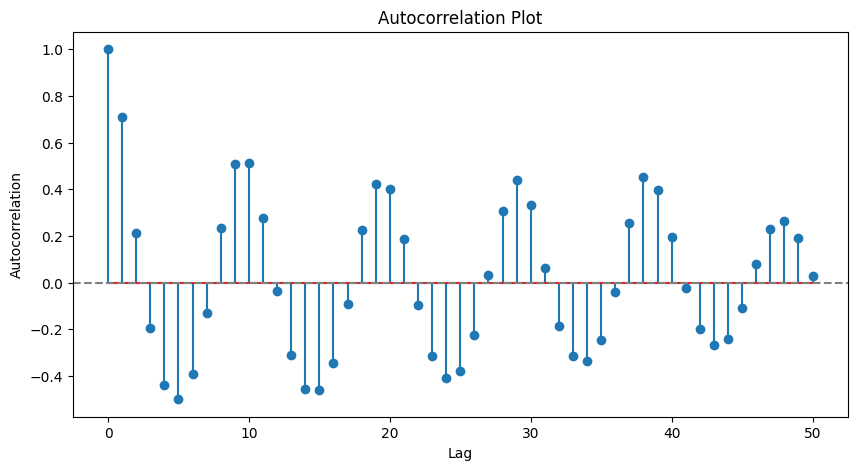

Cyclicity Length: 10
RMSE: 1687.6056232323624


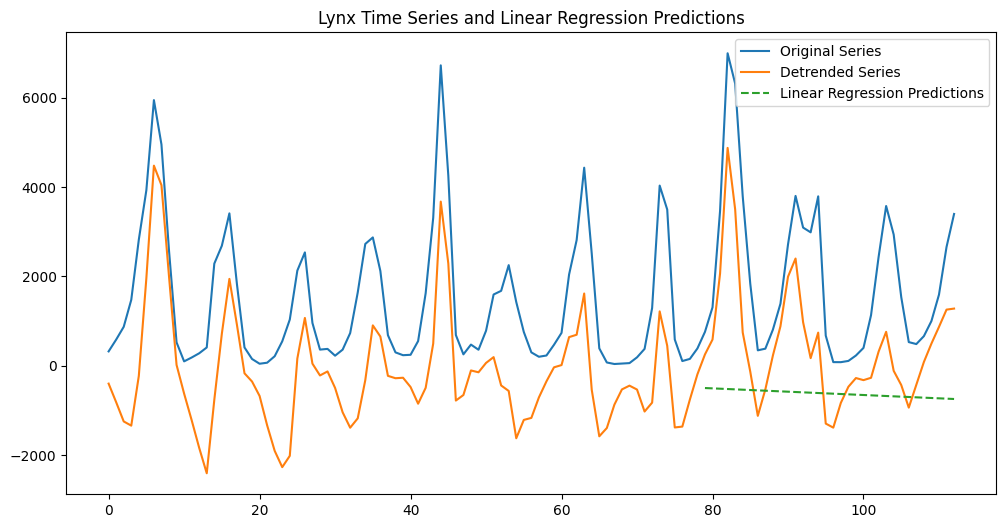

In [24]:
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


lynx_series = load_data()

# Autocorrelation plot
acf_values = plot_autocorrelation(lynx_series)

# Find cyclicity length
cycle_length = find_cyclicity_length(acf_values)
print(f'Cyclicity Length: {cycle_length}')

# Remove cyclicity
if cycle_length:
    detrended_series = subtract_cyclic_average(lynx_series, cycle_length)
else:
    detrended_series = lynx_series

# Prepare features and labels
X, y = prepare_features_and_labels(detrended_series)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Train and predict using linear regression
predictions = linear_regression_model(X_train, y_train, X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse}')

# Plot the original series, detrended series, and predictions
plt.figure(figsize=(12, 6))
plt.plot(lynx_series.index, lynx_series, label='Original Series')
plt.plot(detrended_series.index, detrended_series, label='Detrended Series')
plt.plot(X_test, predictions, label='Linear Regression Predictions', linestyle='--')
plt.legend()
plt.title('Lynx Time Series and Linear Regression Predictions')
plt.show()

# Qno 4
Rewrite the Question-3 using Multilayer Perceptron. Repeat the simulations 10 
independent times and measure the mean train and test RMSE and MAE.

In [25]:
def mlp_model(X_train, y_train, X_test):
    # Train a MLP model
    model = MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', alpha=0.0001, batch_size='auto',
                        learning_rate='constant', learning_rate_init=0.001, shuffle=True,
                        random_state=None)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

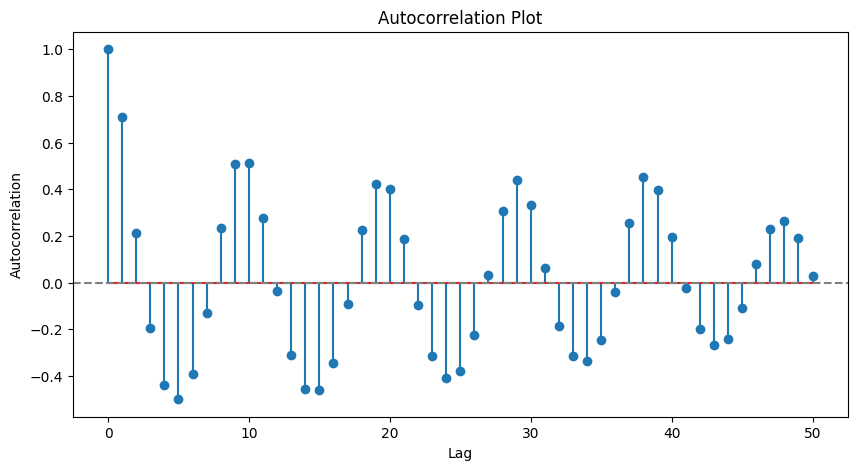

Cyclicity Length: 10
RMSE 1: 1659.5005219491056
RMSE 2: 1657.6902341116972
RMSE 3: 1645.5949218089008
RMSE 4: 1658.1477832235275
RMSE 5: 1645.8124117070915
RMSE 6: 1659.2304775948717
RMSE 7: 1656.8968038490643
RMSE 8: 1645.1152574394566
RMSE 9: 1645.3777696743505
RMSE 10: 1646.6924925134856
Average RMSE: 1652.0058673871554


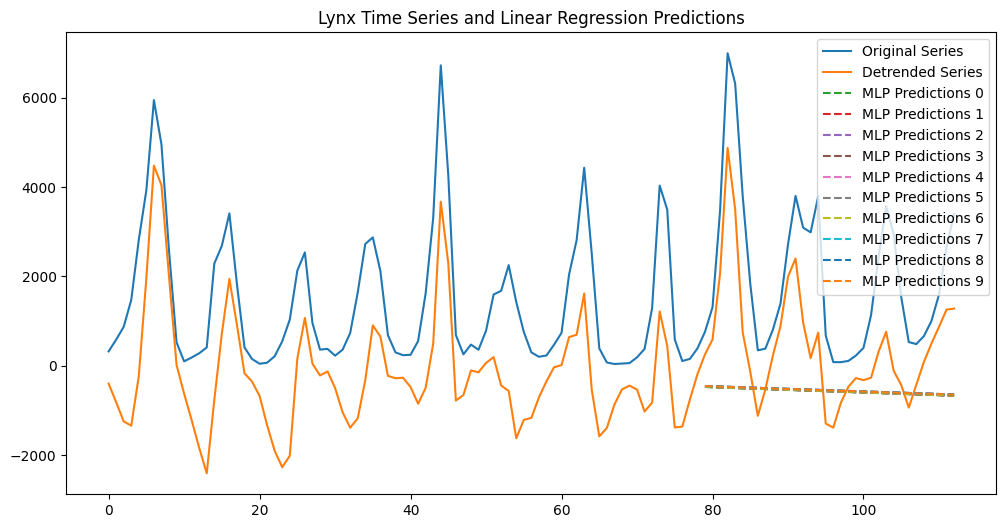

In [26]:
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


lynx_series = load_data()

# Autocorrelation plot
acf_values = plot_autocorrelation(lynx_series)

# Find cyclicity length
cycle_length = find_cyclicity_length(acf_values)
print(f'Cyclicity Length: {cycle_length}')

# Remove cyclicity
if cycle_length:
    detrended_series = subtract_cyclic_average(lynx_series, cycle_length)
else:
    detrended_series = lynx_series

plt.figure(figsize=(12, 6))
plt.plot(lynx_series.index, lynx_series, label='Original Series')
plt.plot(detrended_series.index, detrended_series, label='Detrended Series')

total_rmse = 0

for count in range(10):
    # Prepare features and labels
    X, y = prepare_features_and_labels(detrended_series)

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

    # Train and predict using linear regression
    predictions = mlp_model(X_train, y_train, X_test)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(f'RMSE {count+1}: {rmse}')
    total_rmse += rmse

    plt.plot(X_test, predictions, label=f'MLP Predictions {count}', linestyle='--')

print(f'Average RMSE: {total_rmse / 10}')
plt.legend()
plt.title('Lynx Time Series and Linear Regression Predictions')
plt.show()

# Qno 5
Treat the cyclicity by differencing and predict it using Linear Regression. Use a 70-30 
percent train test split ratio

RMSE: 1670.3683210506654


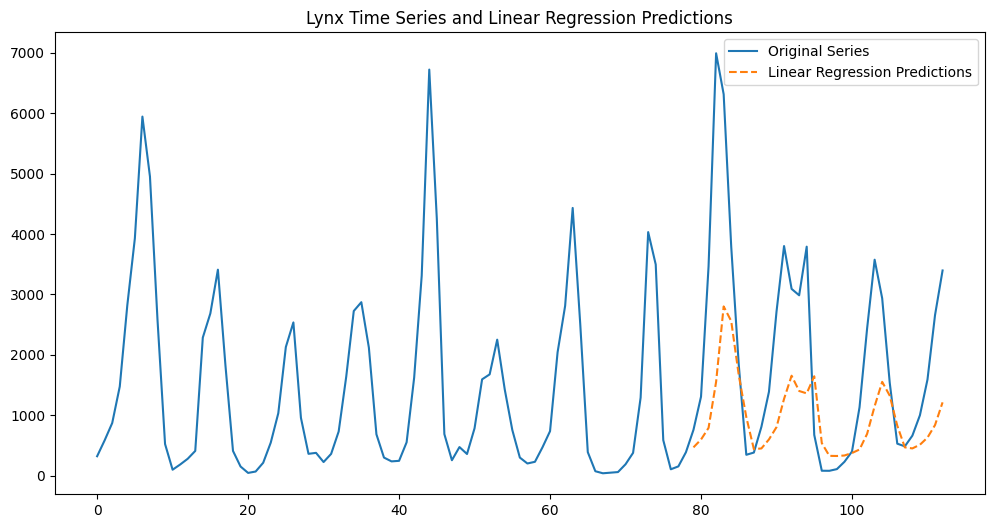

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


def difference_series(time_series):
    # Perform differencing to remove cyclicity
    differenced_series = time_series.diff(periods=1).dropna()
    return differenced_series

def prepare_lagged_features(time_series, lag=1):
    # Create lagged features for regression
    X = pd.concat([time_series.shift(i) for i in range(1, lag + 1)], axis=1).dropna()
    y = time_series[lag:]
    return X.values, y.values

def linear_regression_model(X_train, y_train, X_test):
    # Train a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

def invert_differencing(original_series, differenced_predictions):
    # Invert the differencing to get predictions on the original scale
    last_value = original_series.iloc[-len(differenced_predictions) - 1]
    
    # Initialize list with the last known value
    inverted_predictions = [last_value]
    
    # Add cumulative sum of differences to the last known value
    for diff in differenced_predictions:
        inverted_predictions.append(inverted_predictions[-1] + diff)
    
    # Skip the first value which is just the last known value
    return pd.Series(inverted_predictions[1:], index=original_series.index[-len(differenced_predictions):])



# Load data
lynx_series = load_data()

# Differencing the time series
differenced_series = difference_series(lynx_series)

# Prepare lagged features
X, y = prepare_lagged_features(differenced_series)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Train and predict using linear regression
differenced_predictions = linear_regression_model(X_train, y_train, X_test)

# Invert the differencing to get predictions on the original scale
predictions = invert_differencing(lynx_series, differenced_predictions)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(lynx_series[-len(predictions):], predictions))
print(f'RMSE: {rmse}')

# Plot the original series and predictions
plt.figure(figsize=(12, 6))
plt.plot(lynx_series.index, lynx_series, label='Original Series')
plt.plot(lynx_series.index[-len(predictions):], predictions, label='Linear Regression Predictions', linestyle='--')
plt.legend()
plt.title('Lynx Time Series and Linear Regression Predictions')
plt.show()



# Qno 6
Rewrite the Question-5 using Multilayer Perceptron. Repeat the simulations 10 independent times and measure the mean train and test RMSE and MAE.

In [76]:
def mlp_model(X_train, y_train, X_test):
    # Train a MLP model
    model = MLPRegressor(hidden_layer_sizes=(200, 200), activation='relu', solver='adam', batch_size='auto',
                        learning_rate='constant', learning_rate_init=0.0001, shuffle=False, max_iter=200,
                        random_state=None)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

RMSE 1: 1077.4987819889632
RMSE 2: 1066.2559579387903
RMSE 3: 1099.19315356805
RMSE 4: 1063.671150438309
RMSE 5: 1024.360578160986
RMSE 6: 1022.9526840450752
RMSE 7: 1089.620892027575
RMSE 8: 1100.0629332197382
RMSE 9: 1049.6764177505104
RMSE 10: 990.6206761808055
Average RMSE: 1058.3913225318804


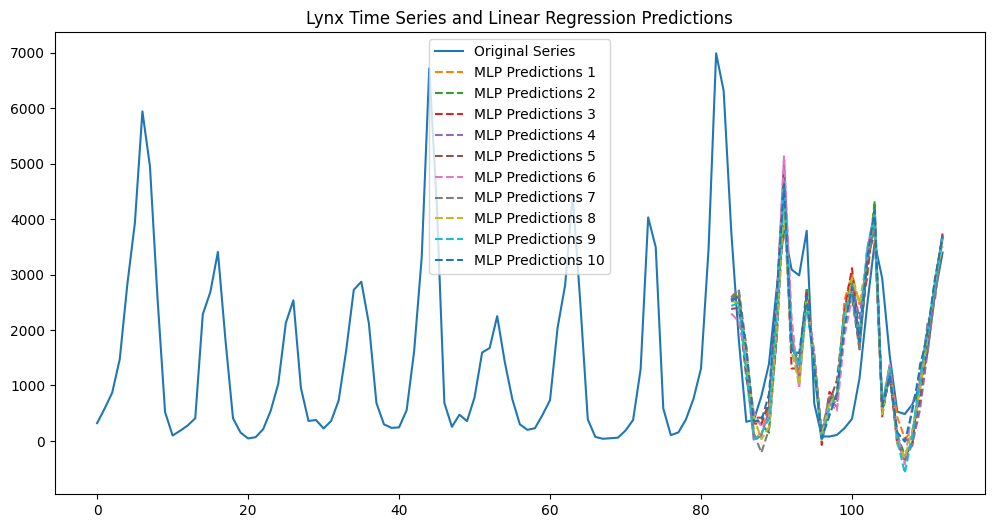

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


def difference_series(time_series):
    # differencing by cyclic period
    differenced_series = time_series.diff(periods=9).dropna()
    return differenced_series

def prepare_lagged_features(time_series, lag=9):
    # Create lagged features for regression
    lagged_data = pd.concat([time_series.shift(i) for i in range(1, lag + 1)], axis=1)
    lagged_data.columns = [f'lag_{i}' for i in range(1, lag + 1)]
    
    # Drop rows with NaN values that result from shifting
    lagged_data.dropna(inplace=True)
    
    # Define target values (shifted by lag)
    y = time_series.iloc[lag:]
    
    # Ensure y is aligned with the lagged_data by trimming the start
    y = y.iloc[:len(lagged_data)]
    
    return lagged_data.values, y.values

def invert_differencing(original_series, differenced_predictions):
    cycle_length = 9
    inverted_predictions = []
    
    # Start inversion process
    for i, diff in enumerate(differenced_predictions):
        # Find the correct point in the original series to add the difference
        reference_point = original_series.iloc[-len(differenced_predictions) - cycle_length + i]
        inverted_value = reference_point + diff
        inverted_predictions.append(inverted_value)
    
    # Convert to pandas Series with correct index
    return pd.Series(inverted_predictions, index=original_series.index[-len(differenced_predictions):])



# Load data
lynx_series = load_data()

# Differencing the time series
differenced_series = difference_series(lynx_series)

# Prepare lagged features
X, y = prepare_lagged_features(differenced_series)


total_rmse = 0
# Split the data into train and test sets
plt.figure(figsize=(12, 6))
plt.plot(lynx_series.index, lynx_series, label='Original Series')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
for count in range(1, 11):

    # Train and predict using linear regression
    differenced_predictions = mlp_model(X_train, y_train, X_test)

    # Invert the differencing to get predictions on the original scale
    predictions = invert_differencing(lynx_series, differenced_predictions)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(lynx_series[-len(predictions):], predictions))
    print(f'RMSE {count}: {rmse}')
    total_rmse += rmse

    # Plot the original series and predictions

    plt.plot(lynx_series.index[-len(predictions):], predictions, label=f'MLP Predictions {count}', linestyle='--')

print(f'Average RMSE: {total_rmse / 10}')

plt.legend()
plt.title('Lynx Time Series and Linear Regression Predictions')
plt.show()




# Qno 7
Models with cyclic treatment generally perform better because they handle the data's inherent structure more effectively. Removing cyclicity often leads to better generalization.